# Portfolio Optimization Using Python

This project takes a look at portfolio optimization by using the Sharpe ratio.

In [27]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
from fredapi import Fred
import matplotlib.pyplot as plt

## 1. Set-up Tickers and Time Range

In [3]:
tickers = ["SPY", "BND", "GLD", "QQQ", "VTI"]

In [4]:
end_date = datetime.today()

In [5]:
start_date = end_date - timedelta(days=3*365)
start_date

datetime.datetime(2021, 11, 3, 23, 48, 16, 354867)

In [ ]:
# adjusted close excludes dividends, etc.
adjusted_close_df = pd.DataFrame()

In [ ]:
# download data
for ticker in tickers: 
    data = yf.download(ticker, start=start_date, end= end_date)
    adjusted_close_df[ticker] = data["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
adjusted_close_df

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2021-11-04 00:00:00+00:00,446.779999,78.138985,167.649994,390.405640,230.664017
2021-11-05 00:00:00+00:00,448.330170,78.376381,169.839996,390.778168,231.552551
2021-11-08 00:00:00+00:00,448.712891,78.202934,170.449997,390.248718,231.934692
2021-11-09 00:00:00+00:00,447.229706,78.422035,171.289993,387.562561,231.265945
2021-11-10 00:00:00+00:00,443.631836,77.892464,173.149994,381.866608,228.992065
...,...,...,...,...,...
2024-10-28 00:00:00+00:00,580.830017,72.841942,253.330002,495.399994,286.700012
2024-10-29 00:00:00+00:00,581.770020,72.901749,256.089996,500.160004,287.079987
2024-10-30 00:00:00+00:00,580.010010,72.831970,257.500000,496.380005,286.369995


## 2. Calculate Log Normal Returns

In [9]:
log_returns = np.log(adjusted_close_df / adjusted_close_df.shift(1))

In [10]:
log_returns = log_returns.dropna()

## 3. Calculate Covariance Matrix

In [11]:
covariance_matrix = log_returns.cov()*252
covariance_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.030986,0.002747,0.004062,0.039917,0.031704
BND,0.002747,0.004828,0.004228,0.003601,0.002902
GLD,0.004062,0.004228,0.020145,0.004453,0.004237
QQQ,0.039917,0.003601,0.004453,0.056765,0.040865
VTI,0.031704,0.002902,0.004237,0.040865,0.032745


## 4. Set-up Portfolio Metrics

### Standard Deviation (risk)

In [12]:
def std_dev(weights, covariance_matrix):
    variance = weights.T @ covariance_matrix @ weights

    return np.sqrt(variance)

### Calculate expected return

In [13]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

### Calculate Sharpe Ratio

In [14]:
def sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate):
    sharpe_ratio_final = (expected_return(weights, log_returns) - risk_free_rate) / std_dev(weights, covariance_matrix)

    return sharpe_ratio_final

In [17]:
risk_free_rate = 0.04

In [ ]:
# fred = Fred(api_key="")
# ten_year = fred.get_series_last_release("GS10") / 100 #div by 100 to get percentage

# risk_free_rate = ten_year.iloc[-1]
# print(risk_free_rate)

## 5. Optimize Portfolio
In this section, I am optimizing the portfolio by minimizing the negative Sharpe ratio.

In [18]:
def neg_sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate):
    neg_sharpe_ratio_final = -sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate)

    return neg_sharpe_ratio_final

In [21]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # make sure weights add up to 1
bounds = [(0, 0.4) for _ in range(len(tickers))] # 0 as lower bound means we can't go short # 0.4, any one asset can't be more than 40%

In [22]:
initial_weights = np.array([1/len(tickers)]*len(tickers)) 
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

## 6. Analyze Optimized Portfolio

In [23]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, covariance_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.47658066326707227
       x: [ 4.000e-01  0.000e+00  4.000e-01  0.000e+00  2.000e-01]
     nit: 4
     jac: [-5.278e-02  2.908e-01 -7.634e-01  1.685e-01  7.721e-02]
    nfev: 24
    njev: 4

In [24]:
optimal_weights = optimized_results.x
optimal_weights

array([0.4, 0. , 0.4, 0. , 0.2])

In [25]:
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimal_weights, covariance_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, covariance_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

SPY: 0.4000
BND: 0.0000
GLD: 0.4000
QQQ: 0.0000
VTI: 0.2000
Expected Annual Return: 0.1013
Expected Volatility: 0.1286
Sharpe Ratio: 0.4766


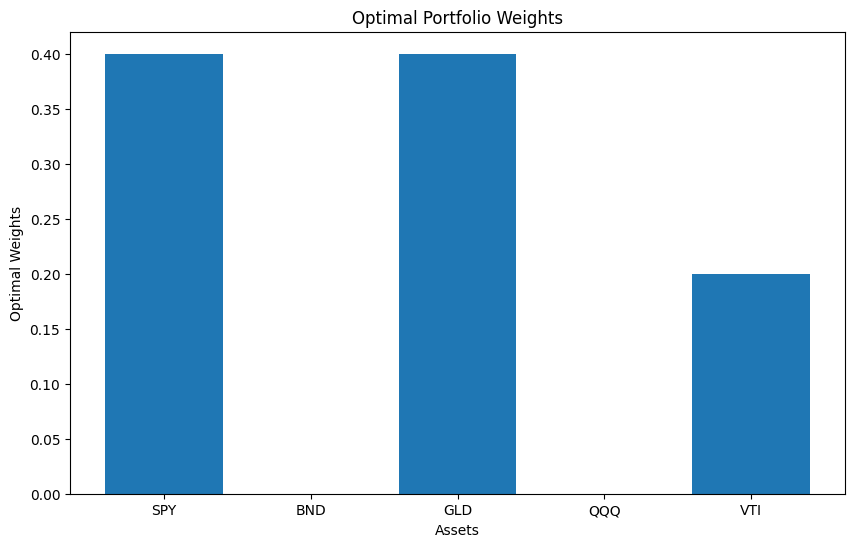

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()